In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 100794245.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39586828.05it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 30813713.10it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16829089.02it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



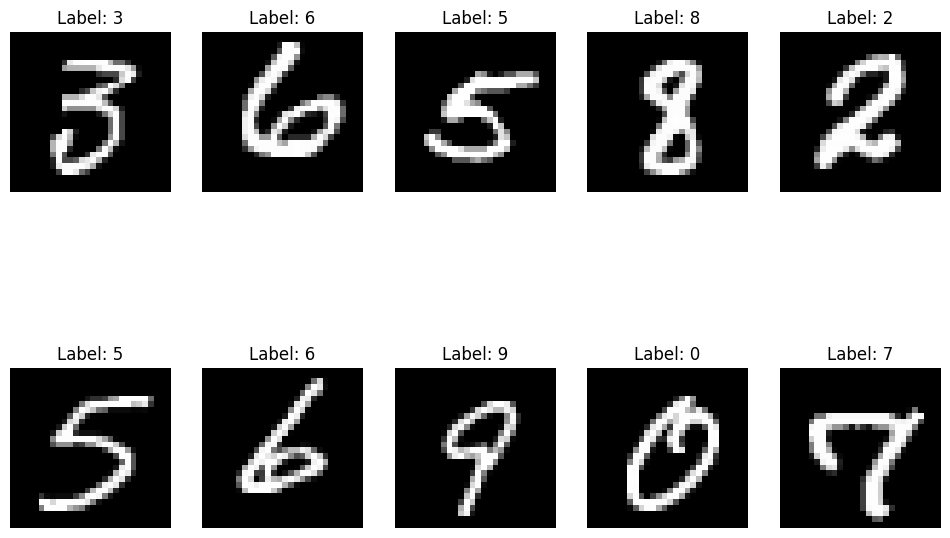

In [ ]:
import random

# Visualize a small sample of MNIST training data
def visualize_mnist_samples(dataset, num_samples=10):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        index = random.randint(0, len(dataset)-1)
        image, label = dataset[index]
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title("Label: {}".format(label))
        plt.axis('off')
    plt.show()

# Visualize MNIST samples
visualize_mnist_samples(train_dataset, num_samples=10)


In [ ]:
# Defined MLP model

class MLP(nn.Module): #subclass MLP inherits from parent class nn.Module and gains access to its functionality for defining and managing neural network modules.
    def __init__(self):
        super(MLP, self).__init__() #used to access methods and attributes defined in the parent class (nn.Module)
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x, char = None):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x_20 = x
        x = self.fc3(x)
        if char == "second_last":
          return x_20
        return x

# Train MLP
def train_mlp(model, train_loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad() # zero out the gradients of previous iteration
            output = model(data) # forward pass of the model
            loss = criterion(output, target) # finding loss using cel
            loss.backward() # finding gradient of loss wrt parameters using backpropagation
            optimizer.step() # updating the gradients

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad(): # no grads required bcoz we are in the testing phase
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1) # returns the max prob of the 10 neurons from the output layer and its corresponding class (1, 2, 3, etc.)
            predictions.extend(predicted.tolist())
            targets.extend(target.tolist())
    return np.array(targets), np.array(predictions)

In [ ]:
import seaborn as sns

# Function for Plotting Confusion Matrix using Heatmap
def conf_mat(y_test, y_pred, name):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

In [ ]:
train_data = train_dataset.data.numpy().reshape(len(train_dataset), -1) #used for rf and lg
test_data = test_dataset.data.numpy().reshape(len(test_dataset), -1) #''
train_labels = train_dataset.targets.numpy() #''
test_labels = test_dataset.targets.numpy()

# MLP training and evaluation

mlp_model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.001, momentum=0.9)
train_mlp(mlp_model, train_loader, optimizer, criterion) #train using train_loader
mlp_true, mlp_pred = evaluate_model(mlp_model, test_loader) #test

In [ ]:
# Train and Evaluate Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(train_data, train_labels)
rf_pred = rf_model.predict(test_data)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(train_data, train_labels)
lr_pred = lr_model.predict(test_data)

# F1 Score Comparison
mlp_f1 = f1_score(mlp_true, mlp_pred, average='weighted') # if we remove average='weighted' then it will calculate f1 score for each class independently which is not what we want. we want the total f1 score
rf_f1 = f1_score(mlp_true, rf_pred, average='weighted')
lr_f1 = f1_score(test_labels, lr_pred, average='weighted')

print("MLP F1-score:", mlp_f1)
print("RF F1-score:", rf_f1)
print("LR F1-score:", lr_f1)

MLP F1-score: 0.9199560039901086
RF F1-score: 0.9682820994739919
LR F1-score: 0.925382715723669


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


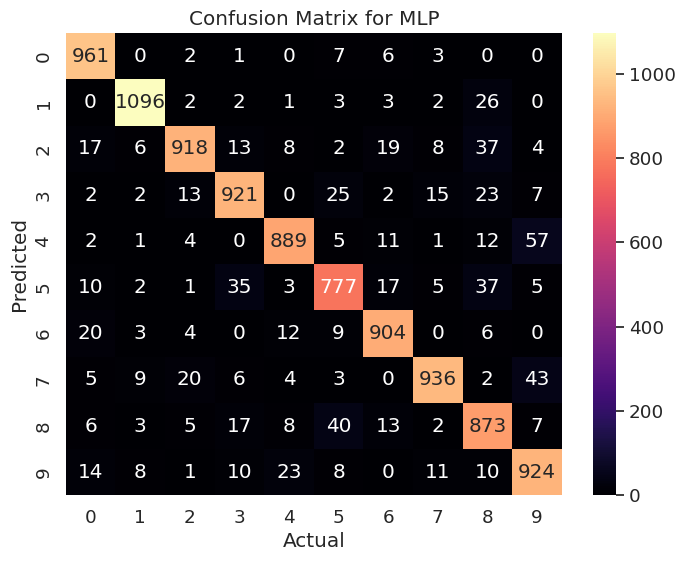

In [ ]:
# Confusion matrix

mlp_cm = conf_mat(mlp_true, mlp_pred, 'MLP')

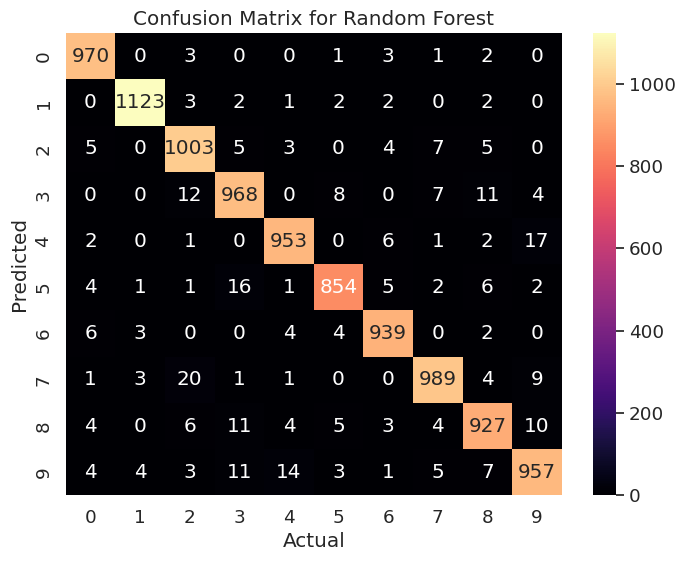

In [ ]:
rf_cm = conf_mat(test_labels, rf_pred, 'Random Forest')

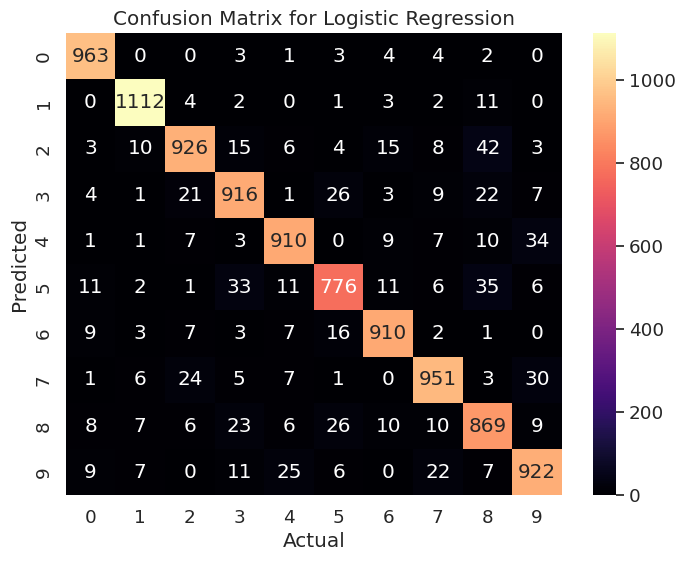

In [ ]:
lr_cm = conf_mat(test_labels, lr_pred, 'Logistic Regression')

**Random Forest** is better than LG because:

**Non-linearity**: Random forests can capture non-linear relationships between features and labels better than logistic regression, which assumes a linear relationship. In image classification tasks like MNIST, there are often complex, non-linear relationships between pixel values and the corresponding digit labels.

**Robustness to noise**: Random forests are generally more robust to noisy data and outliers compared to logistic regression. This robustness can be beneficial when dealing with real-world datasets like MNIST, which may contain some degree of noise.

**Ensemble learning**: Random forests are an ensemble learning method, combining multiple decision trees to make predictions. This ensemble approach helps reduce overfitting and improve generalization performance compared to logistic regression, especially when dealing with high-dimensional datasets like images.

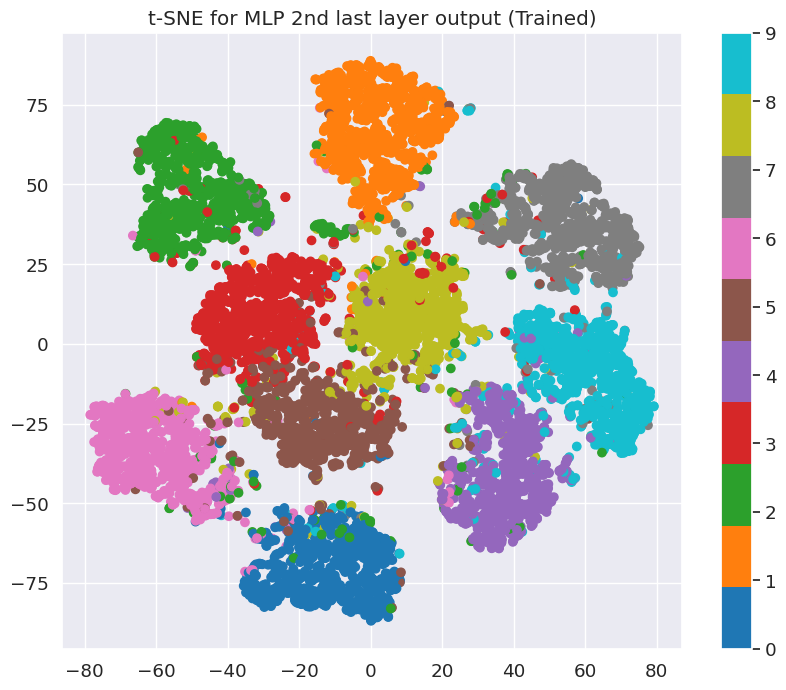

In [ ]:
# t-SNE visualization
def plot_tsne(data, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(data)
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.title(title)
    plt.show()

# t-SNE for MLP output (layer containing 20 neurons)
mlp_2last_layer_output = []
with torch.no_grad():
    for data, _ in test_loader:
        output = mlp_model(data, "second_last")
        mlp_2last_layer_output.extend(output.detach().numpy())
mlp_2last_layer_output = np.array(mlp_2last_layer_output)
plot_tsne(mlp_2last_layer_output, mlp_true, "t-SNE for MLP 2nd last layer output (Trained)")

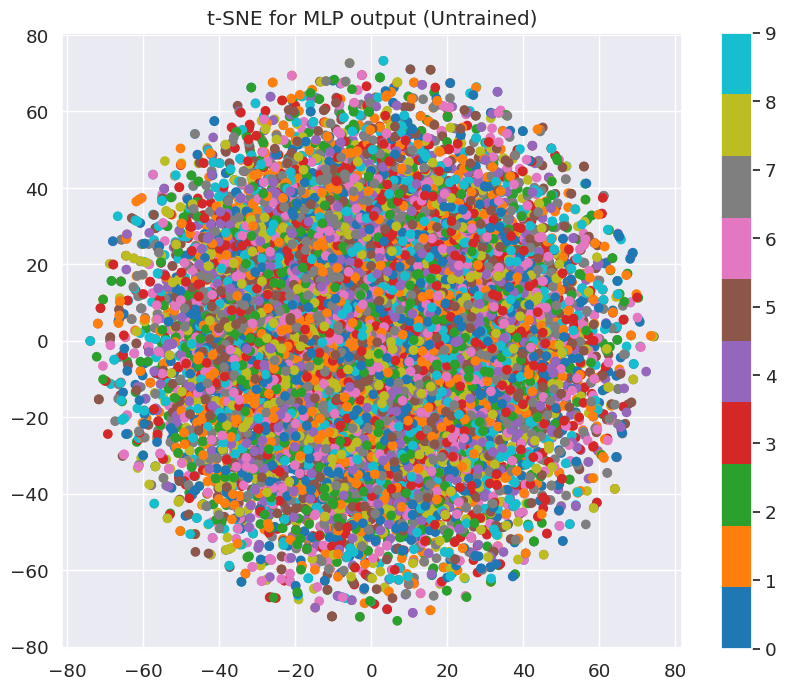

In [ ]:
# t-SNE for untrained MLP
untrained_mlp_layer_output = np.random.randn(len(test_dataset), 20)
plot_tsne(untrained_mlp_layer_output, mlp_true, "t-SNE for MLP output (Untrained)")

**Comparision of Trained and Untrained MLP on t-SNE**

**Cluster Separation**: In the t-SNE plot for the output of the trained MLP, we see well-separated clusters corresponding to the different digit classes (0 through 9). The MLP has learned meaningful representations of the input data, allowing it to distinguish between different digits effectively. In contrast, the t-SNE plot for the untrained model shows poorly separated clusters, reflecting the lack of meaningful representation learning in the absence of training.

**Overlap Between Clusters**: In the t-SNE plot of the trained MLP output, there is some degree of overlap between clusters, particularly for digits that are visually similar (e.g., 4 and 9; 3 and 5 and 8; 2 and 7). However, the overlap is small compared to the untrained model, where clusters overlap significantly.

**Overall Structure**: The t-SNE plot for the trained MLP output exhibits a structured and organized layout, with clear boundaries between different digit classes. In contrast, the t-SNE plot for the untrained model appears chaotic or random, reflecting the absence of learned structure in the representation space.

In [ ]:
# Now, let's use the trained MLP to predict on Fashion-MNIST dataset
transform_fashion = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
fashion_test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform_fashion)
fashion_test_loader = torch.utils.data.DataLoader(fashion_test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 17466191.71it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 303554.24it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5521185.93it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9648023.68it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



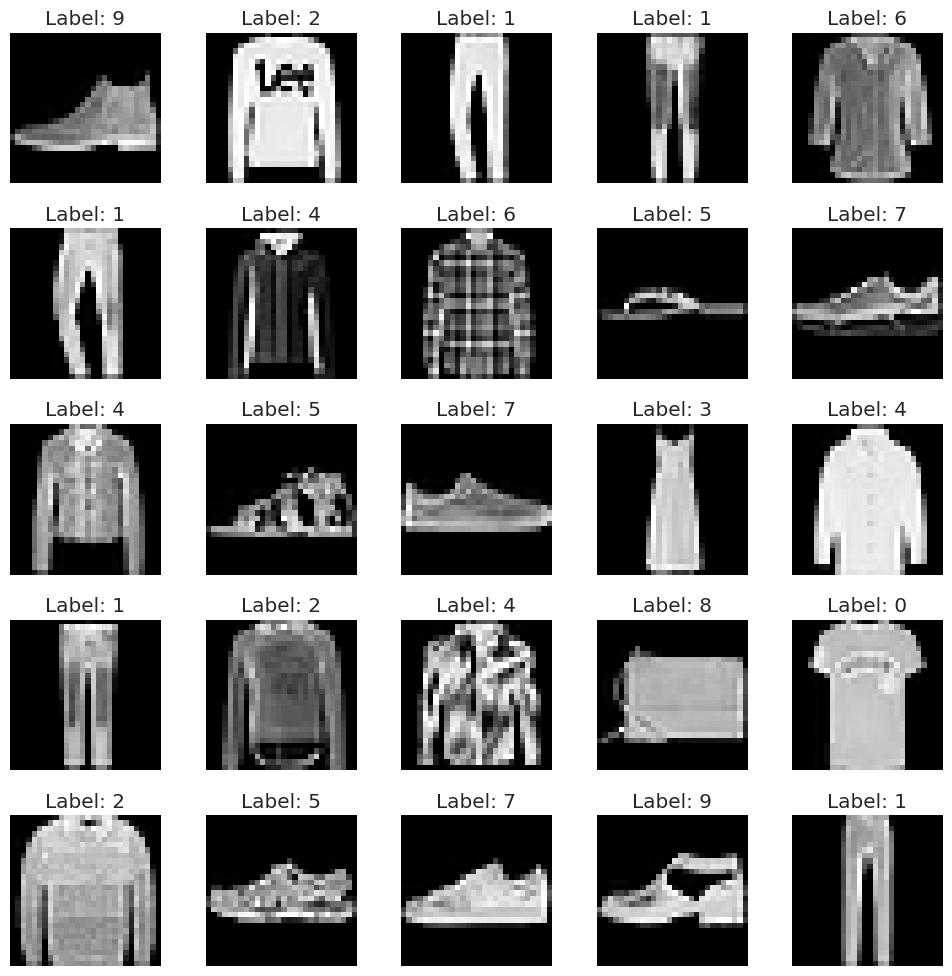

In [ ]:
# Define a function to display a grid of images
def display_images(images, labels, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Take a small subset of images and labels from the fashion test dataset
subset_images = []
subset_labels = []
num_samples = 25  # Number of samples to visualize

for i in range(num_samples):
    subset_images.append(fashion_test_dataset[i][0].squeeze().numpy())
    subset_labels.append(fashion_test_dataset[i][1])

# Display the subset of images
display_images(subset_images, subset_labels, 5, 5)

In [ ]:
# Evaluate MLP on Fashion-MNIST
fashion_mlp_targets, fashion_mlp_pred = evaluate_model(mlp_model, fashion_test_loader)
fashion_mlp_f1 = f1_score(fashion_mlp_targets, fashion_mlp_pred, average='weighted')
print("MLP F1-score on Fashion-MNIST:", fashion_mlp_f1)

MLP F1-score on Fashion-MNIST: 0.03885662492496672


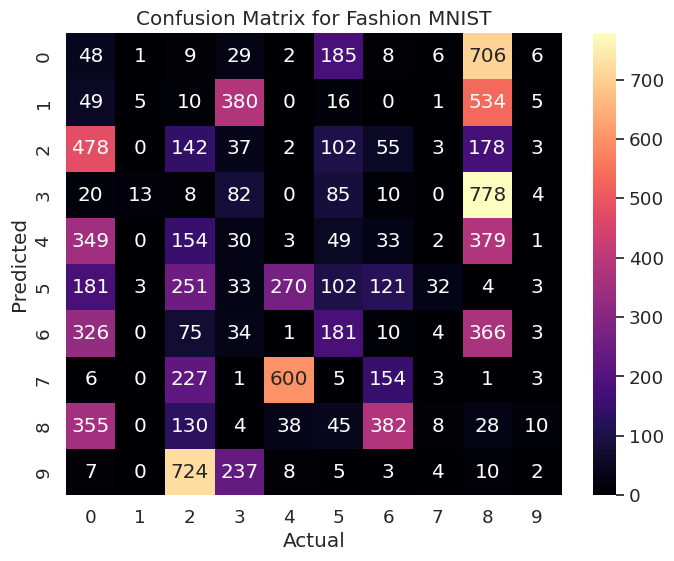

In [ ]:
conf_mat(fashion_mlp_targets, fashion_mlp_pred, 'Fashion MNIST')

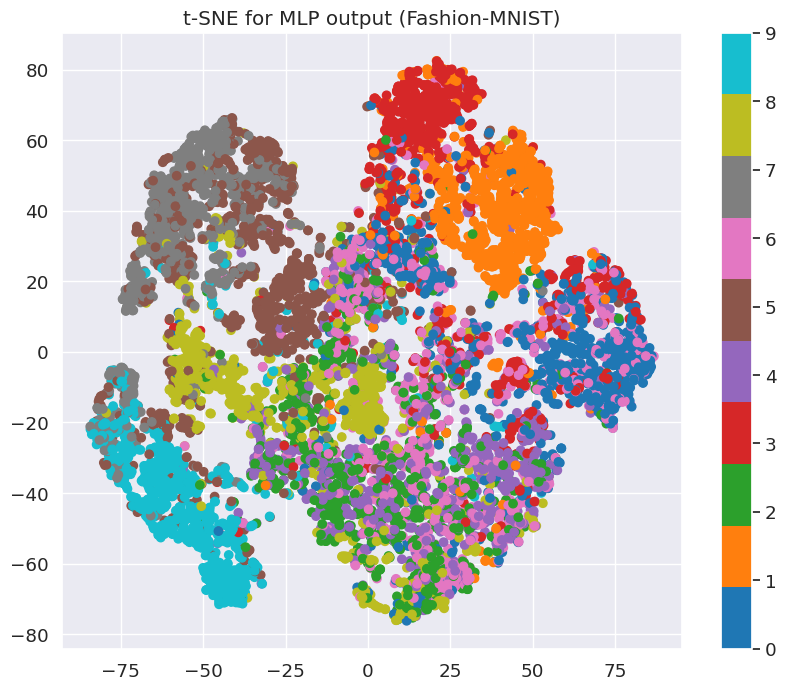

In [ ]:
# Generate t-SNE for Fashion-MNIST
fashion_mlp_layer_output = []
with torch.no_grad():
    for data, _ in fashion_test_loader:
        output = mlp_model(data, 'second_last')
        fashion_mlp_layer_output.extend(output.detach().numpy())
fashion_mlp_layer_output = np.array(fashion_mlp_layer_output)
plot_tsne(fashion_mlp_layer_output, fashion_mlp_targets, "t-SNE for MLP output (Fashion-MNIST)")

**Comparing t-SNE output of Fashion MNIST and normal MNIST**

**Performance Drop and Misclassification**: The performance of the trained MLP model drops when applied to the Fashion-MNIST dataset because the Fashion-MNIST dataset contains images of clothing items rather than handwritten digits, resulting in differences in visual appearance and features that may not have been effectively learned during training on the MNIST dataset.

**Similarities**: Despite differences in the datasets, there are some similarities in the embeddings obtained for MNIST and Fashion-MNIST images. For example, certain clusters in the t-SNE visualization correspond to similar digit classes or clothing categories across both datasets. For example, the class 1 occurs in the upper half of the graph for both datasets.

**Distribution Shift**: The embeddings for Fashion-MNIST images appear more spread out or less well-defined compared to MNIST images due to differences in feature distributions and variability in clothing appearances. This spread reflects the model's struggle to effectively capture and represent the diverse visual features present in the Fashion-MNIST dataset.

In summary, when applying a trained MLP model from the MNIST dataset to predict on the Fashion-MNIST dataset, a performance drop and increased misclassifications are expected due to differences in dataset characteristics. Additionally, while there may be some similarities in the embeddings obtained for MNIST and Fashion-MNIST images, significant differences are also anticipated due to differences in visual features and feature distributions between the two datasets.